<a href="https://colab.research.google.com/github/theAkhileshRai/DeepLearning/blob/master/DCP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sklearn

from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder    

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('/content/DCP_leak_classification_train_data.csv',index_col=False)

In [ ]:
df.head()

,Unnamed: 0,Unnamed: 0.1,time,cyl,s_temp_crank,d_temp_crank,s_pressure_crank,d_pressure_crank,rpm_crank,s_temp_mean,d_temp_mean,s_pressure_mean,d_pressure_mean,rpm_mean,Asset,Binary
0,0,0,2019-12-01 00:30:00,1.0000,103.1136,216.5912,354.6428,836.7407,1357.9325,103.1136,218.0124,344.2387,820.9005,1357.9325,Ashland_Unit256,0.0000
1,1,1,2019-12-01 01:30:00,1.0000,99.9650,214.1369,352.4248,837.7143,1358.2400,99.9650,215.2369,342.9925,822.1540,1358.2400,Ashland_Unit256,0.0000
2,2,2,2019-12-01 02:30:00,1.0000,98.5032,213.4321,352.1486,842.5627,1398.2813,98.5032,214.1066,344.6910,829.0805,1398.2813,Ashland_Unit256,0.0000
3,3,3,2019-12-01 03:30:00,1.0000,104.6202,220.9732,352.7063,848.7154,1397.8712,104.6202,221.6973,345.2832,835.5201,1397.8712,Ashland_Unit256,0.0000
4,4,4,2019-12-01 04:30:00,1.0000,109.5678,227.3392,351.3930,851.2240,1397.3100,109.5678,228.1149,344.0607,838.4339,1397.3100,Ashland_Unit256,0.0000


In [ ]:
len(df['Asset'].unique())

19

In [ ]:
df.shape

(138498, 16)

In [ ]:
df['time'] = pd.to_datetime(df['time'])

In [ ]:
#df['year'] = df['time'].apply(lambda x: x.year)
df['quarter'] = df['time'].apply(lambda x: x.quarter)
df['month'] = df['time'].apply(lambda x: x.month)
df['day'] = df['time'].apply(lambda x: x.day)
df['hour'] = df['time'].apply(lambda x: x.hour)

In [ ]:
df.head()

,Unnamed: 0,Unnamed: 0.1,time,cyl,s_temp_crank,d_temp_crank,s_pressure_crank,d_pressure_crank,rpm_crank,s_temp_mean,d_temp_mean,s_pressure_mean,d_pressure_mean,rpm_mean,Asset,Binary,quarter,month,day,hour
0,0,0,2019-12-01 00:30:00,1.0000,103.1136,216.5912,354.6428,836.7407,1357.9325,103.1136,218.0124,344.2387,820.9005,1357.9325,Ashland_Unit256,0.0000,4,12,1,0
1,1,1,2019-12-01 01:30:00,1.0000,99.9650,214.1369,352.4248,837.7143,1358.2400,99.9650,215.2369,342.9925,822.1540,1358.2400,Ashland_Unit256,0.0000,4,12,1,1
2,2,2,2019-12-01 02:30:00,1.0000,98.5032,213.4321,352.1486,842.5627,1398.2813,98.5032,214.1066,344.6910,829.0805,1398.2813,Ashland_Unit256,0.0000,4,12,1,2
3,3,3,2019-12-01 03:30:00,1.0000,104.6202,220.9732,352.7063,848.7154,1397.8712,104.6202,221.6973,345.2832,835.5201,1397.8712,Ashland_Unit256,0.0000,4,12,1,3
4,4,4,2019-12-01 04:30:00,1.0000,109.5678,227.3392,351.3930,851.2240,1397.3100,109.5678,228.1149,344.0607,838.4339,1397.3100,Ashland_Unit256,0.0000,4,12,1,4


In [ ]:
stat, p = stats.normaltest(df.Binary)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=850048.453, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: -1.4962378363397157
Skewness of normal distribution: 0.7097620472103907


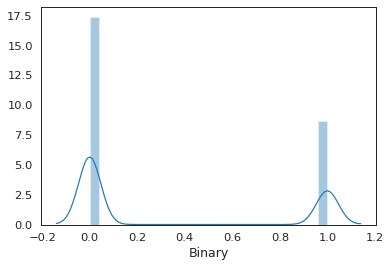

In [ ]:
sns.distplot(df.Binary);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Binary)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Binary)))

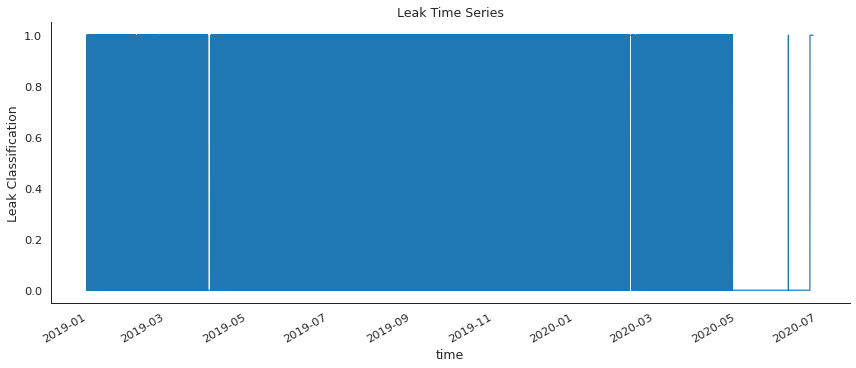

In [ ]:
df1=df.loc[:,['time','Binary']]
df1.set_index('time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Leak Classification')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Leak Time Series')
sns.despine(top=True)
plt.show()

In [ ]:
df['Binary'].shape

(138498,)

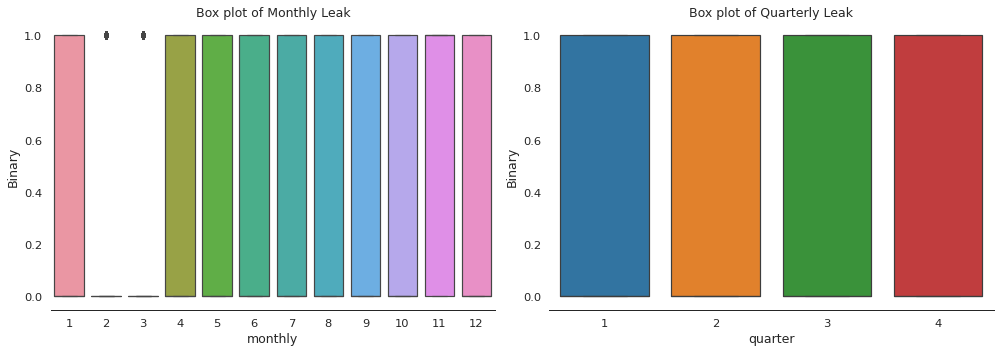

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="month", y="Binary", data=df)
plt.xlabel('monthly')
plt.title('Box plot of Monthly Leak')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Binary", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Leak')
sns.despine(left=True)
plt.tight_layout();

In [ ]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'time', 'cyl', 's_temp_crank',
       'd_temp_crank', 's_pressure_crank', 'd_pressure_crank', 'rpm_crank',
       's_temp_mean', 'd_temp_mean', 's_pressure_mean', 'd_pressure_mean',
       'rpm_mean', 'Asset', 'Binary', 'quarter', 'month', 'day', 'hour'],
      dtype='object')

In [ ]:
X_columns = [ 'quarter','month','day','hour','cyl', 's_temp_crank', 'd_temp_crank', 's_pressure_crank',\
       'd_pressure_crank', 'rpm_crank', 's_temp_mean', 'd_temp_mean',\
       's_pressure_mean', 'd_pressure_mean', 'rpm_mean']

In [ ]:
#time series lstm
X = df[X_columns]
y_true = df.Binary

In [ ]:
seed = 42
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=test_size)

In [ ]:
import numpy as np
# X_train = X_train.values
# X_test = X_test.values
X_train = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
y_test.size

45705

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(LSTM(100,input_shape=(X_train.shape[1], X_train.shape[2])))  # returns a sequence of vectors of dimension 30
#model.add(LSTM(100,input_shape=(X_train.shape[1], X_train.shape[2])))  # return a single vector of dimension 30
# model.add(Dense(50,activation='adam'))
# model.add(Dense(25, activation='adam'))

model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=70, validation_data=(X_test, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 92793 samples, validate on 45705 samples
Epoch 1/20
92793/92793 [==============================] - 6s 65us/step - loss: nan - accuracy: 3.6641e-04 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/20
92793/92793 [==============================] - 5s 58us/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/20
92793/92793 [==============================] - 5s 59us/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/20
92793/92793 [==============================] - 5s 59us/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/20
92793/92793 [==============================] - 6s 61us/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/20
92793/92793 [==============================] - 6s 63us/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/20
92793/92793 [==============================] 